# Trabajo Práctico: Modelos de Difusión para la Generación de Imágenes

## Introducción

Los modelos de difusión son una clase de modelos generativos que aprenden a generar datos de alta calidad revirtiendo un proceso de ruido progresivo. A medida que el modelo se entrena, aprende a deshacer el ruido para recuperar las imágenes originales. En este trabajo práctico, utilizaremos un modelo de difusión preentrenado para generar imágenes del conjunto de datos **CIFAR-10**, un dataset comúnmente usado en visión por computadora que contiene imágenes de 32x32 píxeles de 10 clases diferentes (como perros, gatos, automóviles, etc.).

A lo largo de este notebook, exploraremos cómo el modelo genera imágenes a partir de ruido y cómo diferentes parámetros afectan este proceso.

## Parte 1: Preparación del entorno

Primero, instalaremos y cargaremos las librerías necesarias. Utilizaremos **PyTorch** y el modelo preentrenado desde **Hugging Face**.

In [8]:
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 93.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 89.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 92.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 94.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 99.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 92.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.3/201.3 MB 93.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 90.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: nvidia-nvjitl

In [34]:
import warnings
warnings.filterwarnings("ignore")
import torch
import time
import imageio
import numpy as np
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from diffusers import DDPMPipeline
from matplotlib import pyplot as plt
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import accelerate
import os
from IPython.display import Image

# Crear las carpetas './imgs' y './grid' si no existen
os.makedirs("./imgs", exist_ok=True)
os.makedirs("./grid", exist_ok=True)
os.makedirs("./gifs", exist_ok=True)

## Parte 2: Cargar el modelo preentrenado

Vamos a utilizar un modelo de difusión preentrenado en **CIFAR-10**. Hugging Face ofrece un pipeline ya entrenado que facilita la generación de imágenes.

El modelo pre-entrenado a utilizar se llama DDPM (Denoising Diffusion Probabilistic Models) de Jonathan Ho, Ajay Jain and Pieter Abbeel. Se puede encontrar la documentación en el siguiente link https://huggingface.co/docs/diffusers/api/pipelines/ddpm

In [15]:
# Cargamos el modelo preentrenado DDPMPipeline para CIFAR-10
model_id = "google/ddpm-cifar10-32"
pipeline = DDPMPipeline.from_pretrained(model_id)
pipeline

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--google--ddpm-cifar10-32/snapshots/267b167dc01f0e4e61923ea244e8b988f84deb80.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...: 100%|██████████| 2/2 [00:00<00:00, 25.57it/s]


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.35.2",
  "_name_or_path": "google/ddpm-cifar10-32",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

## Parte 3: Generación de imágenes a partir de ruido

En esta sección, generaremos imágenes usando el modelo preentrenado. Cada imagen comenzará como ruido y el modelo lo "des-noiseará" gradualmente para producir una imagen reconocible.

El proceso de generación toma un número de **timesteps**, que son los pasos intermedios durante los cuales el modelo elimina progresivamente el ruido para obtener una imagen. Podemos ajustar el número de timesteps para ver cómo afecta a la calidad de la imagen.

### Ejercicio:
- ¿Qué sucede durante los "timesteps" en el proceso de generación de imágenes utilizando modelos de difusión?

Durante los "timesteps", el modelo elimina iterativamente el ruido de una imagen ruidosa. Cada timestep representa un paso en el proceso de difusión inversa, donde el modelo predice el ruido añadido en el correspondiente proceso de difusión hacia adelante y lo resta para recuperar una imagen limpia.


- ¿Por qué comenzamos con una imagen completamente de ruido? ¿Qué papel juega el ruido en el proceso de generación de imágenes?

Comenzamos con una imagen de ruido puro porque el modelo de difusión está entrenado para revertir un proceso que convierte las imágenes en ruido. El ruido actúa como punto de partida en el espacio latente. Al partir de un ruido aleatorio, podemos generar imágenes diversas.

- Si la imagen original está completamente cubierta de ruido, ¿cómo es posible que el modelo aprenda a des-noisearla hasta obtener una imagen clara?

El modelo se entrena con un gran conjunto de imágenes. Durante el entrenamiento, aprende la distribución estadística de los datos. No aprende sólo a eliminar el ruido de una única imagen, sino a eliminar el ruido de cualquier imagen de la distribución aprendida. El modelo aprende a predecir el ruido que se añadió en cada paso de tiempo. Al predecir y eliminar iterativamente el ruido, puede reconstruir una imagen coherente con la distribución de datos de entrenamiento.

In [16]:
def plot_imgs(imgs):
    # Mostrar las imágenes generadas
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs[:16]):
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()


100%|██████████| 1/1 [00:00<00:00,  7.80it/s]


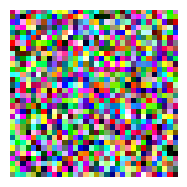

In [17]:
# Generar imágenes
imgs = pipeline(num_inference_steps=1).images
plot_imgs(imgs)

## Parte 4: Explorando los timesteps.

El número de pasos de inferencia (`num_inference_steps`) refiere a los timesteps mencionados anteriormente.

### Ejercicio:
- Completar código.
- Modificar la cantidad de timesteps `num_inference_steps` para ver como varía el resultado (y e tiempo de inferencia) y analizar su impacto.
- ¿Cómo afecta el número de timesteps (pasos de inferencia) a la calidad de las imágenes generadas?

Un mayor número de timesteps generalmente conduce a imágenes de mayor calidad con más detalles. Sin embargo, también aumenta el tiempo de inferencia. Un número muy bajo de timesteps puede dar lugar a imágenes ruidosas o incompletas.

- ¿Cómo describirías visualmente las diferencias entre las imágenes generadas con 10 timesteps y 50 timesteps? ¿Qué esperas observar en cuanto a detalle y nitidez?

Las imágenes generadas con 10 timesteps probablemente serán más borrosas, menos definidas. Las imágenes generadas con 50 timesteps sean más nítidas, más detalladas y se parezcan más a las imágenes del conjunto de datos CIFAR-10.

Generando imágenes con 1 timesteps...


  0%|          | 0/1 [00:00<?, ?it/s]

Tiempo de inferencia: 2.05 segundos


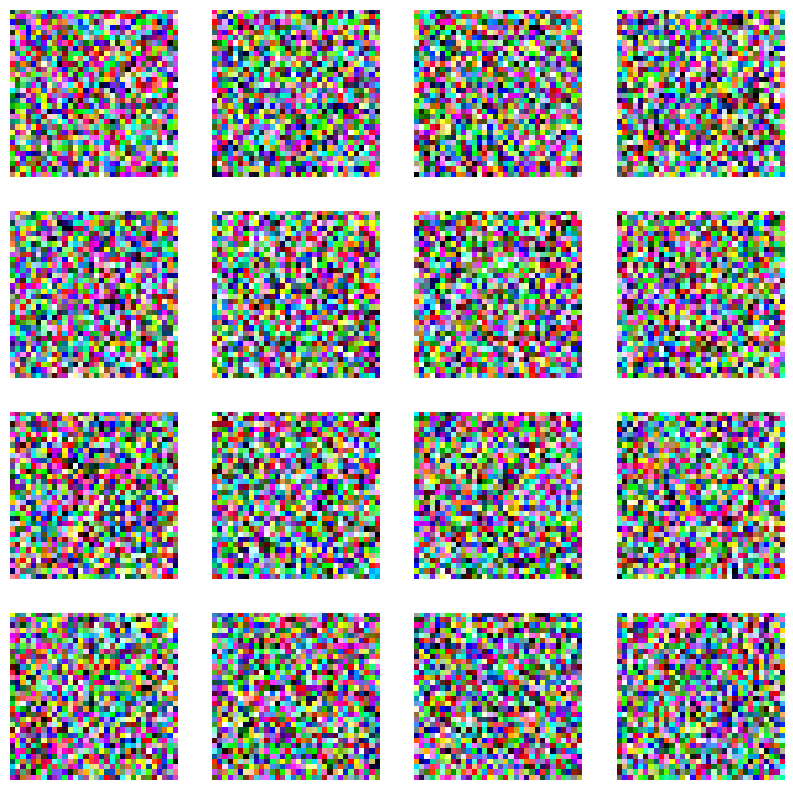

Generando imágenes con 5 timesteps...


  0%|          | 0/5 [00:00<?, ?it/s]

Tiempo de inferencia: 11.20 segundos


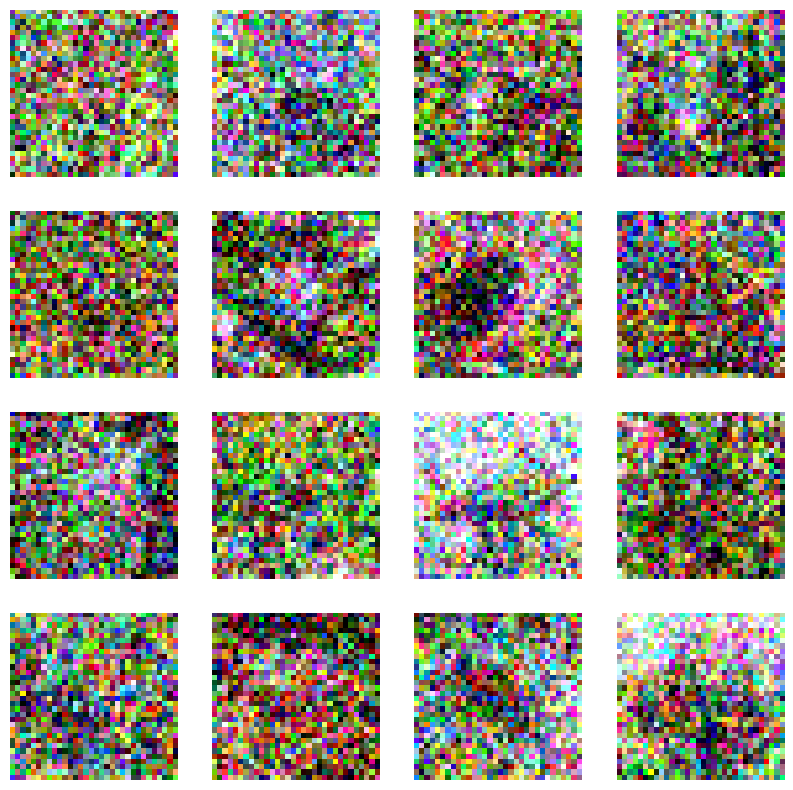

Generando imágenes con 10 timesteps...


  0%|          | 0/10 [00:00<?, ?it/s]

Tiempo de inferencia: 21.18 segundos


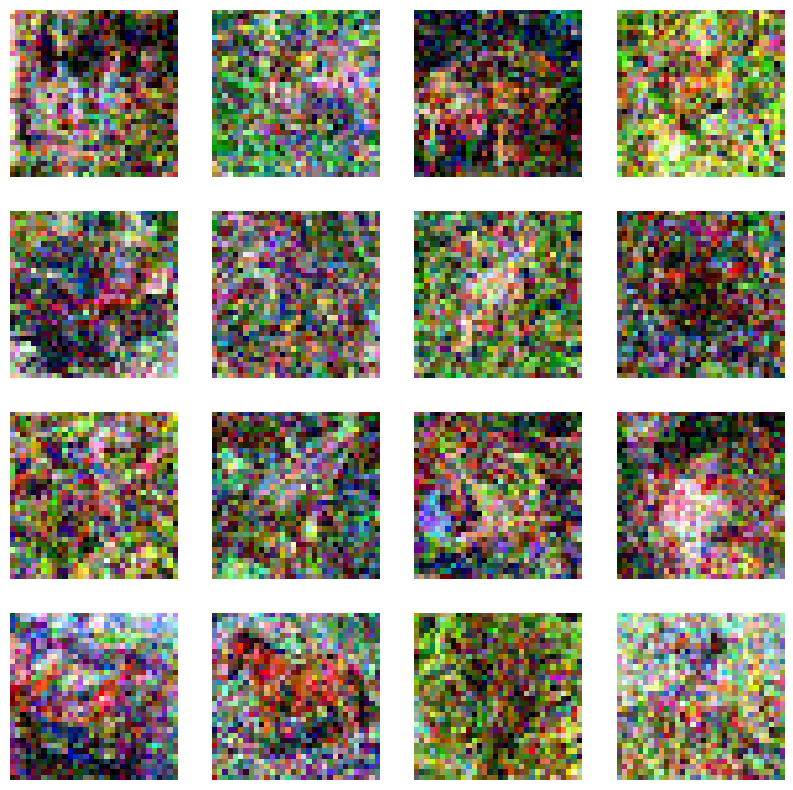

Generando imágenes con 20 timesteps...


  0%|          | 0/20 [00:00<?, ?it/s]

Tiempo de inferencia: 42.49 segundos


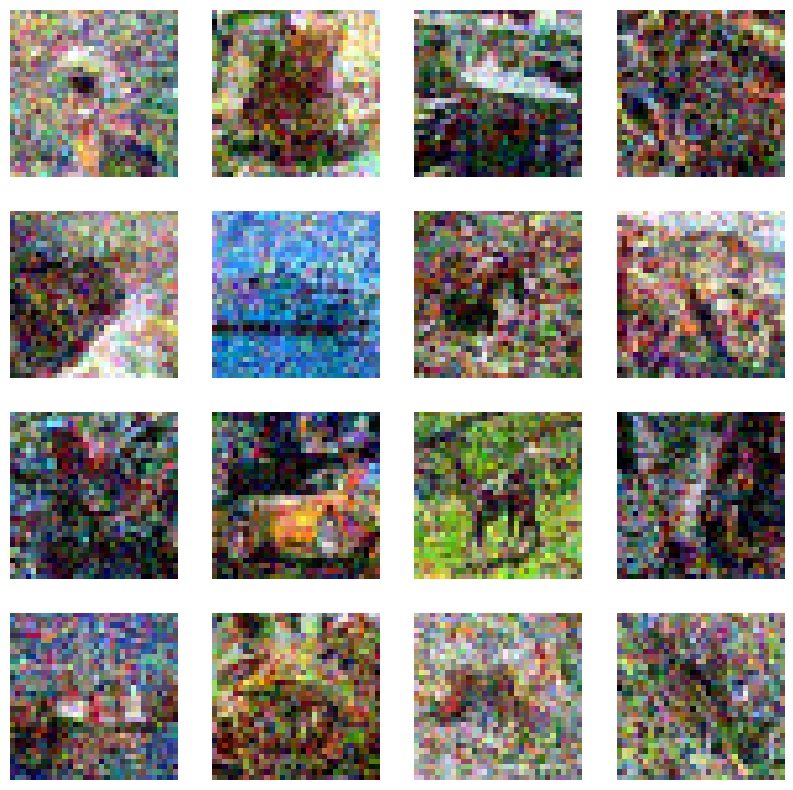

Generando imágenes con 50 timesteps...


  0%|          | 0/50 [00:00<?, ?it/s]

Tiempo de inferencia: 105.72 segundos


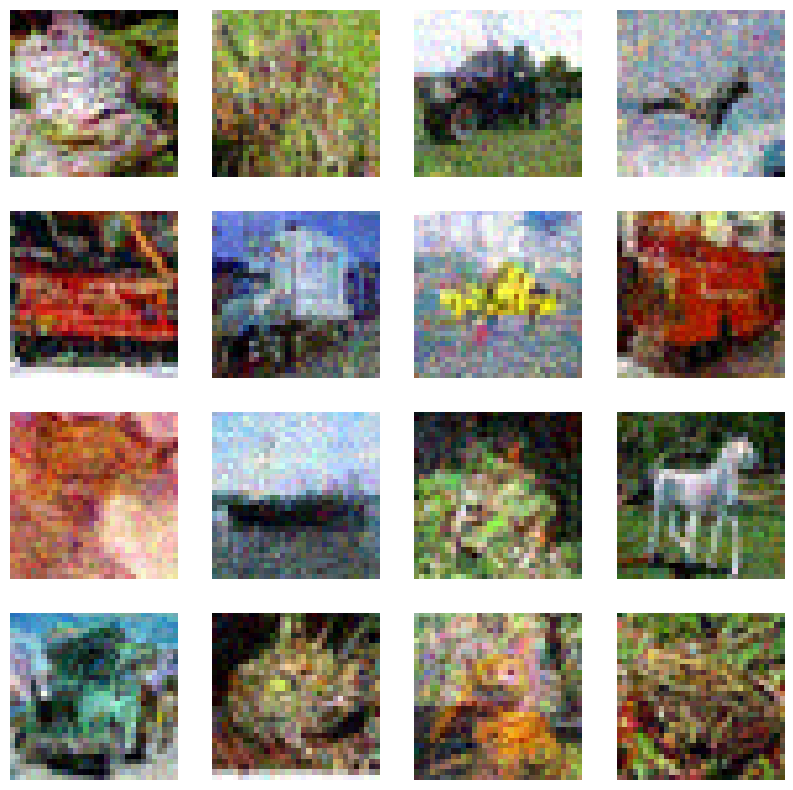

Generando imágenes con 100 timesteps...


  0%|          | 0/100 [00:00<?, ?it/s]

Tiempo de inferencia: 211.22 segundos


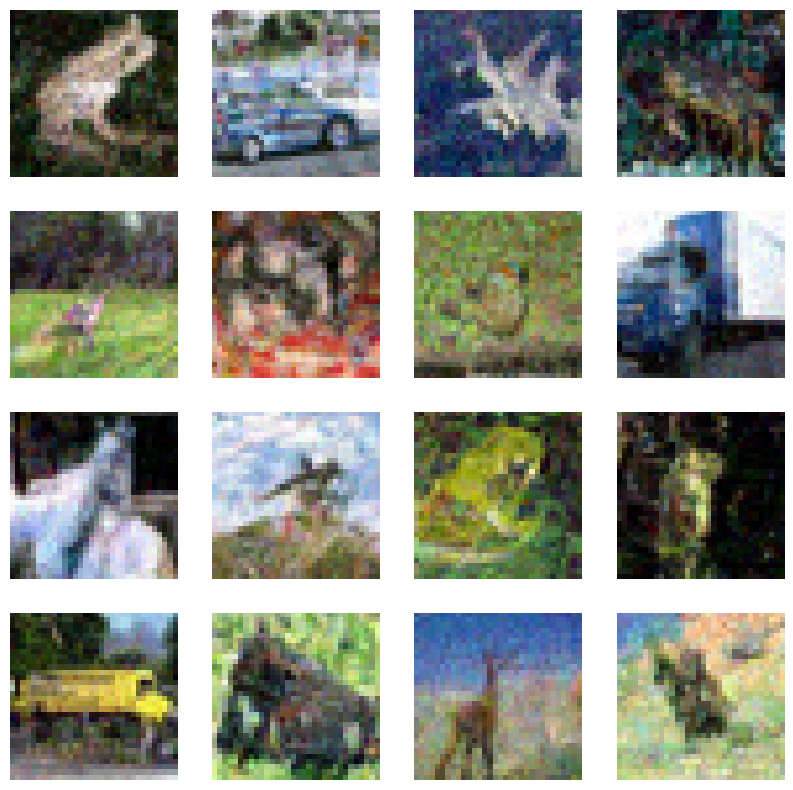

In [ ]:
for steps in [1, 5, 10, 20, 50,100]:
    print(f"Generando imágenes con {steps} timesteps...")
    start_time = time.time()
    imgs = pipeline(num_inference_steps=steps, batch_size=16).images
    end_time = time.time()
    print(f"Tiempo de inferencia: {end_time - start_time:.2f} segundos")
    plot_imgs(imgs)

## Parte 5: Manipulación del ruido

El ruido es una parte crítica del proceso de difusión. A partir de un ruido aleatorio, el modelo de difusión aprende a generar una imagen. Sin embargo, huggingface nos permite manipular la generación de este ruido pasandole una `seed`.

### Ejercicio
- Completar código.
- ¿Qué es una semilla (seed) y por qué es útil en el proceso de generación de ruido en modelos de difusión?

Una semilla es un valor inicial para un generador de números aleatorios. Es útil porque hace que la generación de ruido aleatorio sea determinista. Esto significa que si se utiliza la misma semilla, se obtendrá el mismo ruido y, por lo tanto, la misma imagen generada. Esto es crucial para la reproducibilidad.

- ¿Cómo cambia la imagen generada si utilizas diferentes semillas para el ruido inicial? ¿Esperas que dos imágenes generadas con diferentes semillas sean completamente diferentes o tengan similitudes?

El uso de semillas diferentes producirá un ruido inicial diferente, lo que dará lugar a imágenes completamente distintas. Aunque todas pertenecerán a la misma distribución de datos (por ejemplo, imágenes CIFAR-10).


- Si utilizas la misma semilla para generar ruido dos veces, ¿esperas obtener la misma imagen al final del proceso de denoising? ¿Por qué?

Sí, se esperaría obtener exactamente la misma imagen. La semilla asegura que el ruido inicial sea idéntico y, como el proceso de eliminación de ruido es determinista, el resultado final también será idéntico.

- Modificar la semilla de generación de ruido para ver cómo varía el resultado y ver cómo impacta en la imagen generada.
- ¿Qué observas cuando cambias la semilla pero mantienes el resto de los parámetros del modelo constante?

Cuando se cambia la semilla, se obtiene una imagen generada diferente, pero tendrá el mismo estilo y calidad que la anterior, según lo determinado por los demás parámetros del modelo.

Generando imágenes con seed 42...


  0%|          | 0/100 [00:00<?, ?it/s]

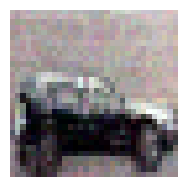

Generando imágenes con seed 123...


  0%|          | 0/100 [00:00<?, ?it/s]

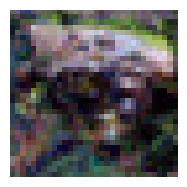

Generando imágenes con seed 999...


  0%|          | 0/100 [00:00<?, ?it/s]

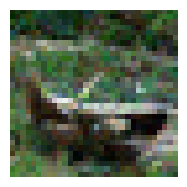

Generando imágenes con seed 42...


  0%|          | 0/100 [00:00<?, ?it/s]

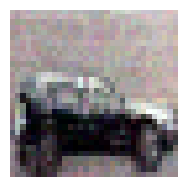

In [ ]:
for seed in [42, 123, 999, 42]:
    print(f"Generando imágenes con seed {seed}...")
    generator = torch.manual_seed(seed)
    imgs = pipeline(num_inference_steps=100, generator=generator).images
    plot_imgs(imgs)

## Parte 6: Generación de imágenes en batch y visualización en grilla

Este proceso genera múltiples imágenes a la vez utilizando un **batch size** definido, y luego organiza esas imágenes en una grilla para visualizarlas.

### Proceso:
1. **Batch de ruido**: Se genera un batch de imágenes de ruido gaussiano utilizando un tamaño de batch específico (por ejemplo, `batch_size=8`).
2. **Generación en paralelo**: El pipeline genera varias imágenes en paralelo utilizando el batch de ruido.
3. **Grilla de imágenes**: Las imágenes generadas se organizan en una grilla utilizando la función `torchvision.utils.make_grid`, lo que permite visualizar varias imágenes en una única figura.

### Ejercicio:
- Completar código.

- Compare el tiempo de inferencia cuando genera en paralelo y secuencialmente (una por una).

La generación de imágenes en paralelo (en un lote) es significativamente más rápida que generarlas secuencialmente.

* En paralelo se generaron las 16 imágenes del lote en 146.62 segundos
* Secuencialmente generamos las 16 imágenes en 178.62 segundos

- Compare el tiempo de inferencia cuando genera varias imagenes en paralelo y una sola.

Generar una sola imagen es más rápido que generar un lote de imágenes. Sin embargo, el tiempo *promedio* por imagen es mucho menor al generar en un lote.

  0%|          | 0/50 [00:00<?, ?it/s]

Tiempo de inferencia para 16 imágenes en paralelo: 105.33 segundos


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Tiempo de inferencia para 16 imágenes secuencialmente: 146.43 segundos


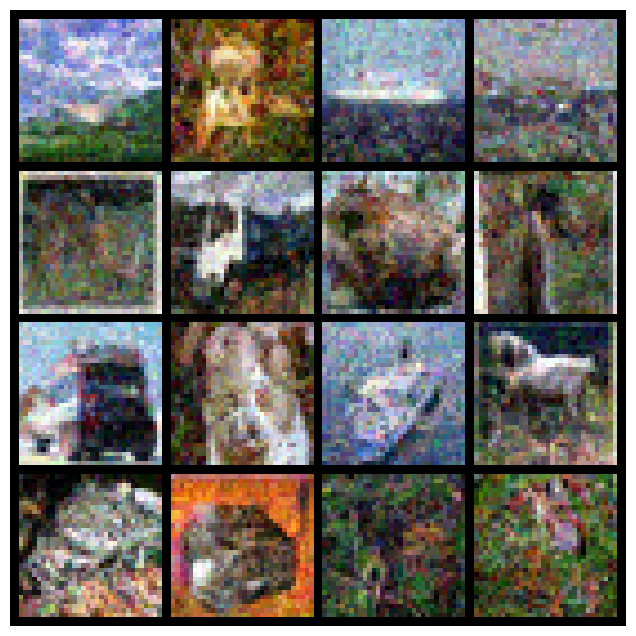

In [ ]:
batch_size = 16
start_time = time.time()
generated_images = pipeline(batch_size=batch_size, num_inference_steps=50).images
end_time = time.time()
print(f"Tiempo de inferencia para {batch_size} imágenes en paralelo: {end_time - start_time:.2f} segundos")

start_time_seq = time.time()
for i in range(batch_size):
    _ = pipeline(batch_size=1, num_inference_steps=50).images
end_time_seq = time.time()
print(f"Tiempo de inferencia para {batch_size} imágenes secuencialmente: {end_time_seq - start_time_seq:.2f} segundos")

# Convertir las imágenes a tensores
image_tensors = [torch.tensor(np.array(img)).permute(2, 0, 1).unsqueeze(0) / 255.0 for img in generated_images]
image_tensors = torch.cat(image_tensors)

# Crear una grilla con las imágenes generadas
grid = make_grid(image_tensors, nrow=4)

# Guardar la grilla como una imagen PNG
save_image(grid, "grid/generated_images_grid.png")

# Visualizar la grilla de imágenes
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.show()

## Parte 7: Generación paso a paso con el scheduler

En este proceso, utilizamos el **scheduler** del pipeline para gestionar la eliminación de ruido de una imagen inicial ruidosa, paso a paso.

### Proceso:

1. **Imagen inicial**: Comenzamos con una imagen de ruido gaussiano.
2. **Scheduler**: El **scheduler** controla cómo se elimina el ruido en cada paso, utilizando el modelo **UNet** para predecir y reducir el ruido progresivamente. El scheduler se encarga de realizar los pasos de denoising de manera estable.
3. **Captura de imágenes intermedias**: Guardamos las imágenes intermedias en intervalos específicos para visualizar cómo la imagen final emerge del ruido.
4. **Visualización**: Al final, se crea un GIF mostrando todo el proceso de generación, desde el ruido hasta la imagen final.

### Ejercicio:
- Completar código.
- ¿Qué observas al capturar imágenes intermedias durante el proceso de denoising? ¿Cómo cambia la imagen en cada paso?

Se puede observar cómo la imagen se va formando partiendo desde el ruido. En los primeros pasos, la imagen es muy ruidosa. A medida que el proceso avanza empezamos a ver más detalle y formas.

- Explore con los parámetros `step_size` y `num_inference_steps`. ¿Para qué sirven?

`num_inference_steps` es el número total de pasos de eliminación de ruido. `step_size` determina la frecuencia con la que guardamos una imagen intermedia. Un `step_size` más pequeño dará como resultado más imágenes intermedias y un GIF más suave.

- ¿Qué podemos aprender del GIF generado a partir de imágenes intermedias? ¿Qué observas sobre el proceso desde una imagen completamente ruidosa hasta una clara?

El GIF nos da una comprensión visual del proceso de difusión inversa. Muestra cómo el modelo parte del ruido e iterativamente crea una imagen coherente.

- ¿Por qué es útil visualizar el proceso de denoising paso a paso? ¿Cómo te ayuda esto a entender el funcionamiento del modelo de difusión?

Esto nos da una intuición sobre cómo funciona el modelo en inferencia. Y puede ayudar a entender si el modelo esta fallando. Por ejemplo, si las imágenes generadas no son buenas, observar los pasos intermedios puede ayudar a entender dónde está fallando el proceso.

In [18]:
# Función para generar imágenes paso a paso con acceso al ruido intermedio
def generate_images_with_intermediate_steps(pipeline, noise, scheduler, num_inference_steps, step_size=1):
    images = []
    image = noise  # Imagen inicial con ruido

    for t in range(num_inference_steps):
        # Obtener el valor de timestep actual
        current_timestep = scheduler.timesteps[t]

        # El modelo predice el ruido en la imagen
        with torch.no_grad():
            model_output = pipeline.unet(image, current_timestep).sample  # Predecir el ruido

        # Realizar el paso del scheduler para actualizar la imagen con menos ruido
        image = scheduler.step(model_output, current_timestep, image).prev_sample

        # Guardar las imágenes en intervalos de step_size
        if t % step_size == 0:
            images.append(image.clone())  # Guardar imagen intermedia
            save_image(image, f"imgs/step_{t}.png")  # Guardar como PNG

    return images


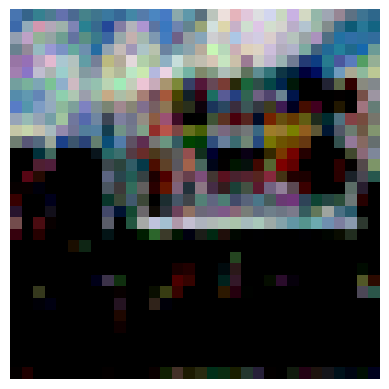

In [ ]:
step_size = 2
num_inference_steps = 100
img_shape = (1, 3, 32, 32)

# Acceder al scheduler desde el pipeline
scheduler = pipeline.scheduler
scheduler.set_timesteps(num_inference_steps)

# Crear una imagen de ruido inicial (completamente ruidosa)
initial_noise = torch.randn(img_shape)

# Generar las imágenes paso a paso
images = generate_images_with_intermediate_steps(pipeline, initial_noise, scheduler, num_inference_steps, step_size)

# Visualizar la última imagen generada
final_image = images[-1].squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow(final_image)
plt.axis('off')
plt.show()

image_paths = [f"imgs/step_{t}.png" for t in range(0, num_inference_steps, step_size)]
images_gif = [imageio.imread(path) for path in image_paths]
imageio.mimsave("gifs/step_by_step.gif", images_gif)

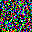

In [ ]:
from IPython.display import Image
Image(filename='gifs/step_by_step.gif', width=500)

## Parte 8: Exploración del espacio latente entre dos imagenes

Vamos explorar el espacio latente entre dos imágenes. El objetivo es ver si podemos encontrar alguna relación entre las imagenes generadas por el movimiento del espacio latente entre dos imagenes.

### Proceso:
1. Generar dos estructuras con ruido diferente.
2. Interpolar entre ambas estructuras utilizando un valor de `alpha` que cambia de 0 a 1.
3. Pasar este ruido por el modelo de difusión.
4. Visualizar las imágenes generadas para observar la transición.

### Ejercicio:
- Completar código.
- ¿Qué es el espacio latente en un modelo de difusión y cómo se relaciona con las imágenes generadas?

En un modelo de difusión, el espacio latente es el espacio de las imágenes ruidosas. Cada punto de este espacio corresponde a una imagen potencial que se puede generar. El vector de ruido inicial es un punto en este espacio latente.

- ¿Qué sucede cuando interpolamos entre dos estructuras de ruido diferentes utilizando un valor de alpha? ¿Qué esperarías ver en las imágenes generadas?

Cuando se interpola entre dos estructuras de ruido esperariamos ver una transición suave entre la imagen correspondiente al primer vector de ruido y la imagen correspondiente al segundo.

- Al visualizar las imágenes generadas por la interpolación, ¿observas alguna relación coherente entre las imágenes? ¿Las imágenes de la transición muestran características de ambas imágenes originales?

A diferencia de lo que imaginabamos no observamos una transición gradual entre la imagen 1 y la 2 (de un objeto a otro), si podemos observar algún cambio progresivo en texturas o colores. El espacio latente es de alta dimension por lo que la influencia de cadda una de las 2 imagenes se observa en propiedades de bajo nivel (colores, contrastes, etc.)

In [56]:
def denoise_image(unet_model, noisy_image, scheduler, num_inference_steps, num_steps_added_noise=0):
    image = noisy_image
    for t in range(num_inference_steps - num_steps_added_noise, num_inference_steps):
        current_timestep = scheduler.timesteps[t]
        with torch.no_grad():
            model_output = unet_model(image, current_timestep).sample
        image = scheduler.step(model_output, current_timestep, image).prev_sample
    return image

In [61]:
num_inference_steps = 100
scheduler = pipeline.scheduler
scheduler.set_timesteps(num_inference_steps)

image1_tensor = torch.randn((1, 3, 32, 32))
image2_tensor = torch.randn((1, 3, 32, 32))

steps = 10
interpolated_images = []
for alpha in np.linspace(0, 1, steps):
    interpolated_noise = (1 - alpha) * image1_tensor + alpha * image2_tensor
    interpolated_image = denoise_image(pipeline.unet, interpolated_noise, scheduler, num_inference_steps, 100)
    interpolated_images.append(interpolated_image.cpu().detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8889378..0.8594366].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.7266005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.80820584].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.96545935].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9616079].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9860673..0.7967571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8127237..1.0].
Clipping inpu

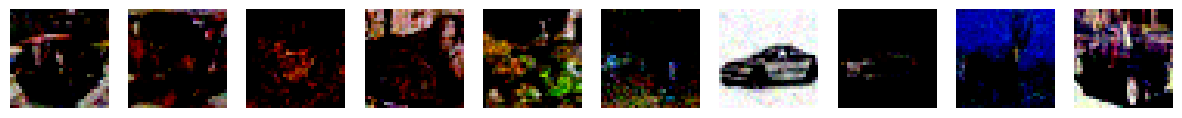

In [62]:
# Visualización de las imágenes interpoladas
plt.figure(figsize=(15, 3))
for i, img_tensor in enumerate(interpolated_images):
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    plt.subplot(1, steps, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Crear el GIF de la interpolación
images_for_gif = []
for img_tensor in interpolated_images:
    img = img_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    img_uint8 = (img * 255).astype(np.uint8)  # Convertir a formato uint8 para el GIF
    images_for_gif.append(img_uint8)

# Guardar el GIF
imageio.mimsave('gifs/interpolation.gif', images_for_gif, duration=2)

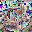

In [64]:
Image(filename='gifs/interpolation.gif', width=500)

## Parte 9: Añadir ruido controlado a una imagen real y eliminarlo

Vamos a tomar una imagen real del dataset, añadirle una cantidad controlada de ruido y luego intentaremos eliminar ese ruido utilizando el pipeline de difusión. Este proceso nos permitirá observar cómo el modelo reconstruye la imagen eliminando el ruido añadido.

### Pasos:
1. Seleccionar una imagen real del dataset CIFAR-10.
2. Añadir ruido gaussiano controlado a la imagen.
3. Usar el pipeline de difusión para eliminar el ruido y reconstruir la imagen original.

Este ejercicio ayuda a entender cómo los modelos de difusión pueden realizar la tarea de denoising en imágenes.

### Ejercicio:
- Completar código.
- ¿Qué es el ruido gaussiano y por qué lo añadimos a una imagen real en este ejercicio?
  
El ruido gaussiano es un tipo de ruido estadístico que tiene una función de densidad de probabilidad igual a la de la distribución normal. Lo añadimos a una imagen real para simular el proceso de difusión hacia adelante. Esto nos permite probar la capacidad del modelo para eliminar el ruido de una imagen que no ha visto en su forma ruidosa durante el entrenamiento.

- ¿Cómo afecta la cantidad de ruido añadido a la imagen al proceso de denoising? ¿Qué esperarías que ocurriera si añades mucho ruido en comparación con poco?
  
Cuanto más ruido se añade, más difícil es para el modelo reconstruir la imagen original. Con una pequeña cantidad de ruido, el modelo debería ser capaz de reconstruir la imagen casi perfectamente. Con una gran cantidad de ruido, la imagen reconstruida podría perder algunos detalles.

- Si la cantidad de ruido añadido es muy alta, ¿crees que el modelo podrá eliminar todo el ruido y restaurar completamente la imagen original? ¿Por qué?
  
Si el ruido es demasiado alto, es posible que el modelo no pueda restaurar completamente la imagen original. Esto se debe a que un nivel muy alto de ruido puede ocultar las características de la imagen original hasta el punto de que el modelo no pueda recuperarlas.

- ¿En qué escenarios prácticos crees que se podría aplicar este proceso de denoising en imágenes reales? ¿Qué aplicaciones puedes imaginar para esta técnica?
    * Eliminación de ruido de fotos antiguas o de baja calidad.
    * Arte digital y edición de fotos.
    * Reconocimiento de rostros y chapas de auto

In [49]:
# Cargar el dataset CIFAR-10 y seleccionar una imagen
transform = transforms.Compose([transforms.ToTensor()])
dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
image, _ = next(iter(dataloader))  # Tomar una imagen del dataset

# Acceder al UNet y el scheduler del pipeline
unet_model = pipeline.unet
scheduler = pipeline.scheduler

100%|██████████| 170M/170M [00:10<00:00, 16.5MB/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4896054..2.728739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2775804..0.9665317].


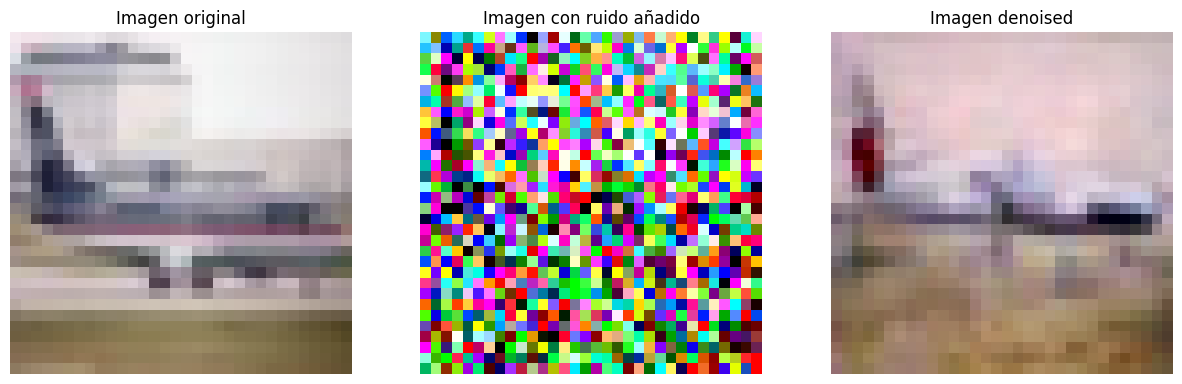

In [67]:
# Configurar el scheduler con el número de pasos
num_inference_steps = 1000
num_steps_added_noise = 200
scheduler.set_timesteps(num_inference_steps)

# Añadir ruido en el último paso del scheduler
timestep = scheduler.timesteps[-num_steps_added_noise]  # Tomar el último paso de la programación de ruido
with torch.no_grad():
    noisy_image = scheduler.add_noise(image, torch.randn_like(image), timestep)  # Añadir ruido

# Aplicar el proceso de denoising a la imagen ruidosa
denoised_image = denoise_image(unet_model, noisy_image, scheduler, num_inference_steps, num_steps_added_noise)

# Visualización de la imagen original, la imagen con ruido y la imagen denoised
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Imagen original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Imagen con ruido añadido")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title("Imagen denoised")
plt.axis('off')

plt.show()